In [18]:
%%capture
!git clone https://github.com/maziarraissi/PINNs

In [19]:
import tensorflow as tf
import numpy as np
import os
from time import time

In [20]:
#Pysichs-Informed Neural Network per la risoluzione dell'equazione di Burgers
#Iper-parametri per testing
#Dimensioni data points
#def num_hidden_layers = 8 // num_neurons_per_layer = 20
N_0 = 200 #da testare 20 40 60 80 100 200
N_b = N_0
N_r = 8000 #da testare 2000 4000 6000 7000 8000 10000

#Architettura rete neurale
#def N_b = N_0 = 100 // N_r = 10000

num_hidden_layers = 8 #da testare 2 4 6 8
num_neurons_per_layer = 40 #da testare 10 20 40



DTYPE = 'float32'

tf.keras.backend.set_floatx(DTYPE)

pi = tf.constant(np.pi, dtype=DTYPE)
viscosity = .01/pi
tf.random.set_seed(5_000)

In [21]:
#Definizione domini t e x
tmin = 0
tmax = 1
xmin = -1
xmax = 1

#Lower bounds
lb = tf.constant([tmin, xmin], DTYPE)
#Upper bounds
ub = tf.constant([tmax, xmax], DTYPE)

In [22]:
#Definizione condizioni iniziali
def fun_u_0(x):
  return -tf.sin(pi*x)

def fun_u_b(t, x):
  n = x.shape[0]
  return tf.zeros((n,1), dtype=DTYPE)

def fun_r(t, x, u, u_t, u_x, u_xx):
  return u_t+u*u_x - viscosity*u_xx

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [23]:
repoPath = os.path.join(".", "PINNs")
appDataPath = os.path.join(repoPath, "appendix", "Data")
path = os.path.join(appDataPath, "burgers_shock.mat")

In [24]:
#Generazione casuale dei punti per condizioni iniziali
t_0 = tf.ones((N_0, 1), dtype=DTYPE)*lb[0]
x_0 = tf.random.uniform((N_0, 1), lb[1], ub[1], dtype=DTYPE)
X_0 = tf.concat([t_0, x_0], axis=1)

#Valore delle condizioni iniziali per t = 0
u_0 = fun_u_0(x_0)

#Boundary data
t_b = tf.random.uniform((N_b, 1), lb[0], ub[0], dtype=DTYPE)
x_b = lb[1]+(ub[1]-lb[1])*tf.keras.backend.random_bernoulli((N_b, 1), 0.5, dtype=DTYPE)
X_b = tf.concat([t_b, x_b], axis=1)

#Valutazione della boundary condition in (t_b, x_b)
u_b = fun_u_b(t_b, x_b)

#Generazione casuale dei punti di collocazione
t_r = tf.random.uniform((N_r, 1), lb[0], ub[0], dtype=DTYPE)
x_r = tf.random.uniform((N_r, 1), lb[1], ub[0], dtype=DTYPE)
X_r = tf.concat([t_r, x_r], axis=1)

#Salvataggio dati in liste
X_data = [X_0, X_b]
u_data = [u_0, u_b]

In [25]:
#1.3 Architettura della rete

def init_model(num_hidden_layers=8, num_neurons_per_layer=20):
  #Inizializzazione della rete neurale feedforward
  model = tf.keras.Sequential()

  #Input di tipo bi-dimensionale (tempo + una dimensione spaziale)
  model.add(tf.keras.Input(shape=(2, )))

  #Scaling layer per mappare l'input in [lb, ub]
  scaling_layer = tf.keras.layers.Lambda(
      lambda x: 2.0*(x-lb)/(ub-lb)-1.0)
  model.add(scaling_layer)

  #Hidden layers
  for _ in range(num_hidden_layers):
    model.add(tf.keras.layers.Dense(num_neurons_per_layer,
        activation=tf.keras.activations.get('tanh'),
        kernel_initializer='glorot_normal'))

  #Output mono-dimensionale
  model.add(tf.keras.layers.Dense(1))

  return model

#1.4 Routines per calcolo delle loss

def get_r(model, X_r):
  #tf.GradientTape è usato per il calcolo delle derivate in TensorFlow
  with tf.GradientTape(persistent=True) as tape:
    #Split di t e x per il calcolo delle derivate parziali
    t, x = X_r[:, 0:1], X_r[:,1:2]

    #Le variabili t e x sono dichiarate 'watched'
    #per il calcolo di u_t e di u_x
    tape.watch(t)
    tape.watch(x)

    #Calcolo del residuo
    input_data = tf.stack([t[:,0], x[:,0]], axis=1)
    u = model(input_data)

    #Calcolo del gradiente u_x tramite Gradient Type
    #per il calcolo di u_xx
    u_x = tape.gradient(u, x)

  u_t = tape.gradient(u, t)
  u_xx = tape.gradient(u_x, x)

  del tape

  return fun_r(t, x, u, u_t, u_x, u_xx)

def compute_loss(model, X_r, X_data, u_data):

  #Calcolo phi r
  r = get_r(model, X_r)
  phi_r = tf.reduce_mean(tf.square(r))

  #Inizializzazione loss
  loss = phi_r

  #aggiunta di phi^0 e phi^b alla loss
  for i in range (len(X_data)):
    u_pred = model(X_data[i])
    loss += tf.reduce_mean(tf.square(u_data[i] - u_pred))

  return loss

def get_grad(model, X_r, X_data, u_data):

  with tf.GradientTape(persistent=True) as tape:
    #Il tape permette il calcolo delle derivate
    #rispetto alle trainable variables
    loss = compute_loss(model, X_r, X_data, u_data)

    g = tape.gradient(loss, model.trainable_variables)
    del tape

    return loss, g

#Definizione di un train step (epoca)
@tf.function
def train_step():
  # Calcolo della loss corrente e del gradiente rispetto ai parametri
  loss, grad_theta = get_grad(model, X_r, X_data, u_data)

  #Esecuzione di un gradient step
  optim.apply_gradients(zip(grad_theta, model.trainable_variables))

  return loss

In [26]:
#Inizializzazione del modello, ossia u_\theta

model = init_model(num_hidden_layers, num_neurons_per_layer)

#Il learning rate è costante a tratti, decrescente
#nelle prime 1000 epoche il learning rate è pari a 0.01
#da 1000 - 3000: learning rate = 0.001
#da 3000 in poi: learning rate = 0.0005

lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([1000, 3000], [1e-2, 1e-3, 5e-4])

#Scelta dell'optimizer
optim = tf.keras.optimizers.Adam(learning_rate=lr)

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lambda_1 (Lambda)                    │ (None, 2)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 40)                  │             120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 40)                  │           1,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 40)                  │           1,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 40)                  │           1,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 40)                  │           1,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 40)                  │           1,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 40)                  │           1,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 40)                  │           1,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 1)                   │              41 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,641 (45.47 KB)

 Trainable params: 11,641 (45.47 KB)

 Non-trainable params: 0 (0.00 B)

In [27]:
#Numero di epoche per il train del modello
N_epoch = 5000
hist = []

#Start timer
t0 = time()

for i in range(N_epoch+1):

  loss = train_step()

  #Salvataggio della loss nella cronologia hist
  hist.append(loss.numpy())

  #Ogni 50 iterazioni, stampa della loss


  if i%100 == 0:
    print('It {:05d}: loss = {:10.8e}'.format(i, loss))


#Stampa tempo di computazione
training_time = time()-t0
print('\nTraining time :{} seconds'.format(training_time))

It 00000: loss = 1.49967718e+00
It 00100: loss = 1.11292340e-01
It 00200: loss = 6.96462542e-02
It 00300: loss = 2.13239312e-01
It 00400: loss = 9.04331133e-02
It 00500: loss = 2.00129896e-01
It 00600: loss = 1.05354697e-01
It 00700: loss = 7.98344910e-02
It 00800: loss = 1.91343322e-01
It 00900: loss = 1.08848728e-01
It 01000: loss = 8.35874379e-02
It 01100: loss = 6.93526343e-02
It 01200: loss = 5.39259985e-02
It 01300: loss = 3.70041616e-02
It 01400: loss = 2.71487217e-02
It 01500: loss = 1.89684127e-02
It 01600: loss = 1.37446010e-02
It 01700: loss = 1.62102096e-02
It 01800: loss = 6.65212236e-03
It 01900: loss = 5.04841283e-03
It 02000: loss = 3.48171243e-03
It 02100: loss = 2.93186726e-03
It 02200: loss = 2.61106389e-03
It 02300: loss = 2.33106338e-03
It 02400: loss = 1.74301246e-03
It 02500: loss = 1.49110449e-03
It 02600: loss = 1.31361536e-03
It 02700: loss = 1.30020990e-03
It 02800: loss = 1.02918898e-03
It 02900: loss = 3.01636220e-03
It 03000: loss = 8.00075359e-04
It 03100

In [28]:
from PIL import Image
from pathlib import Path
import scipy.io
import matplotlib.pyplot as plt

In [29]:
## Calcolo U_pred
#Set up meshgrid

N_x = 255
N_t = 99
tspace = np.linspace(lb[0], ub[0], N_t+1)
xspace = np.linspace(lb[1], ub[1], N_x+1)
T, X = np.meshgrid(tspace, xspace)
Xgrid = np.vstack([T.flatten(), X.flatten()]).T

In [30]:
#Calcolo della predizione u(t,x)
upred = model(tf.cast(Xgrid,DTYPE))
#Reshape upred
U_pred = upred.numpy().reshape(N_x+1, N_t+1)

In [31]:
##Load U_exact
#t ha dimensione 100x1, x ha la dimensione x is 256x1, usol ha dimensione 256x100]
data = scipy.io.loadmat(path)
#Flatten trasforma [[]] in [], [:,None] lo trasforma in un vettore colonna
t = data['t'].flatten()[:,None] #T x 1
x = data['x'].flatten()[:,None] #N x 1
#La soluzione è di dimensione T x N
U_exact = np.real(data['usol']).T #T x N

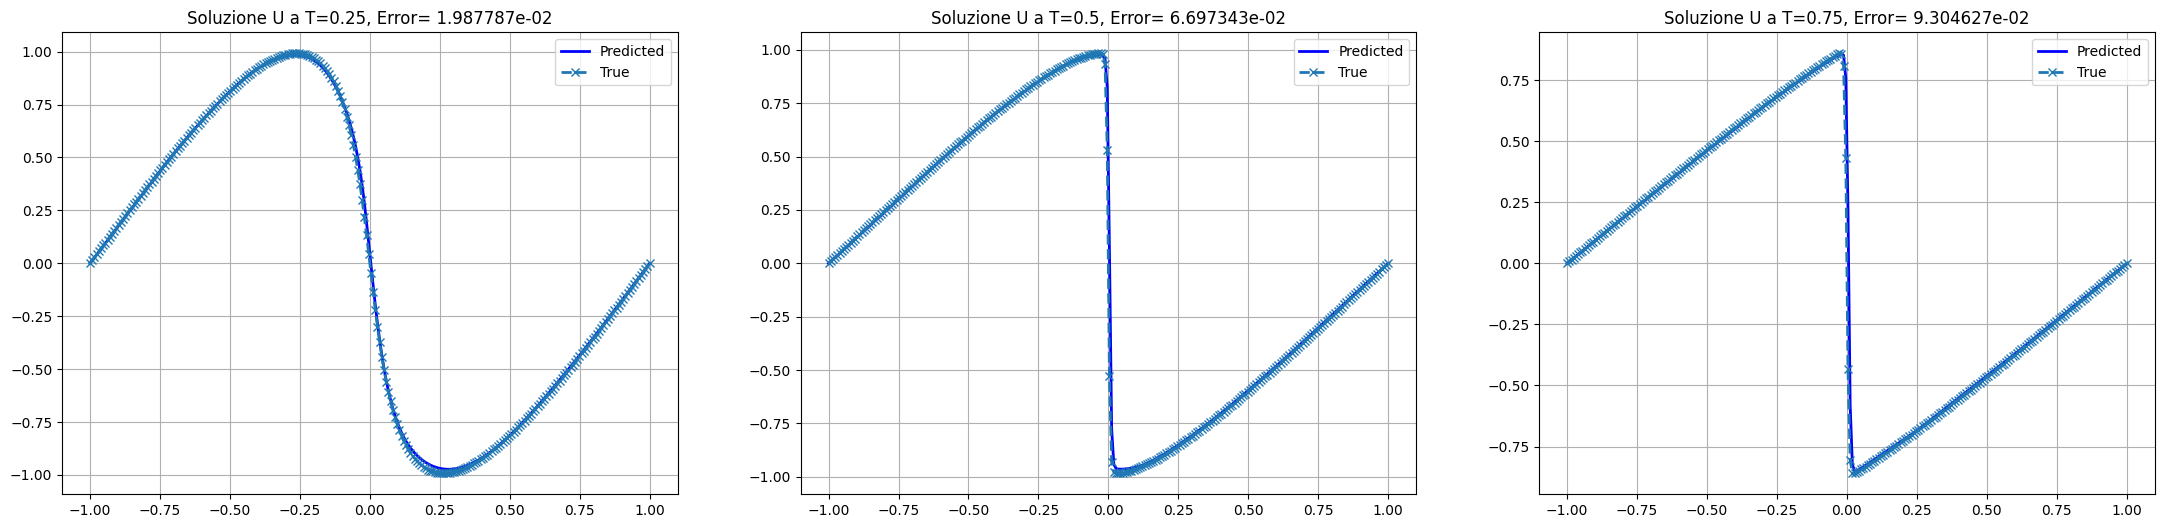

In [32]:
#Creazione della figura e dei tre grafici
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(27,6))

#Scelta dell'istante di tempo T desiderato
T_desired = 0.25
#Estrazione delle previsioni del modello all'istante di tempo T_desired
idx_T_desired = np.where(np.isclose(tspace, T_desired, atol=0.01))[0][0] #Trova l'indice più vicino a T_desired
U_pred_at_T = U_pred[:,idx_T_desired]
#Estrazione della soluzione esatta all'istante di tempo T_desired
idx_T_desired = np.where(np.isclose(t, T_desired, atol=0.01))[0][0]
U_exact_at_T = U_exact[idx_T_desired,:]

error = np.linalg.norm(U_exact_at_T - U_pred_at_T, 2) / np.linalg.norm(U_exact_at_T, 2)

ax1.plot(xspace, U_pred_at_T, 'b-', linewidth=2, label='Predicted')
ax1.plot(x, U_exact_at_T, 'x--', linewidth=2, label='True')
ax1.set_title(f'Soluzione U a T={T_desired}, Error={error: 2e}')
ax1.legend()
ax1.grid(True)

#Scelta dell'istante di tempo T desiderato

T_desired = 0.5
#Estrazione delle previsioni del modello all'istante di tempo T_desired
idx_T_desired = np.where(np.isclose(tspace, T_desired,atol=0.01))[0][0]

U_pred_at_T = U_pred[:,idx_T_desired]
#Estrazione della soluzione esatta all'istante di tempo T_desired
idx_T_desired = np.where(np.isclose(t, T_desired, atol=0.01))[0][0]
U_exact_at_T = U_exact[idx_T_desired,:]

error = np.linalg.norm(U_exact_at_T - U_pred_at_T, 2) / np.linalg.norm(U_exact_at_T, 2)

ax2.plot(xspace, U_pred_at_T, 'b-', linewidth=2, label='Predicted')
ax2.plot(x, U_exact_at_T, 'x--', linewidth=2, label='True')
ax2.set_title(f'Soluzione U a T={T_desired}, Error={error: 2e}')
ax2.legend()
ax2.grid(True)

#Scelta dell'istante di tempo T desiderato

T_desired = 0.75
#Estrazione delle previsioni del modello all'istante di tempo T_desired
idx_T_desired = np.where(np.isclose(tspace, T_desired,atol=0.01))[0][0]

U_pred_at_T = U_pred[:,idx_T_desired]
#Estrazione della soluzione esatta all'istante di tempo T_desired
idx_T_desired = np.where(np.isclose(t, T_desired, atol=0.01))[0][0]
U_exact_at_T = U_exact[idx_T_desired,:]

error = np.linalg.norm(U_exact_at_T - U_pred_at_T, 2) / np.linalg.norm(U_exact_at_T, 2)

ax3.plot(xspace, U_pred_at_T, 'b-', linewidth=2, label='Predicted')
ax3.plot(x, U_exact_at_T, 'x--', linewidth=2, label='True')
ax3.set_title(f'Soluzione U a T={T_desired}, Error={error: 2e}')
ax3.legend()
ax3.grid(True)

img_name = f"test_Nu{N_0}_Nf{N_r}_Hlayers{num_hidden_layers}_neuron{num_neurons_per_layer}.jpg"
parent_path = r"/content/drive/MyDrive/PINN_Burgers_TEST"
plt.savefig = (f"/content/drive/MyDrive/PINN_Burgers_TEST/{img_name}")

In [33]:
error = np.linalg.norm(U_exact - U_pred.T, 2) / np.linalg.norm(U_exact, 2)
print(format(error,'.1E'))

6.1E-02


In [ ]:
#Apro il file in modalità lettura e scrittura

file_name = "PINN_Burgers_TEST_results.txt"
with open(f"/content/drive/MyDrive/PINN_Burgers_TEST/{file_name}", 'r+') as file:
  #Leggo il contenuto attuale del file
  contenuto = file.read()

  #Scrivo una nuova riga sotto il contenuto attuale
  nuova_riga = f"test_Nu{N_0}_Nf{N_r}_Hlayers{num_hidden_layers}_neuron{num_neurons_per_layer}___time={training_time('1E')}__loss={hist[-1]}"
  file.write('\n' + nuova_riga)

  #Chiudo il file per salvarlo
  file.close()

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/PINN_Burgers_TEST/PINN_Burgers_TEST_results.txt'